We extract the outputs of each layer from the CaffeNet model based on the network architecture of Krizhevsky et al. for ImageNet. The point of this is to see what the CNN will do when given:

    a) conflicting textual and visual information,
    b) a digital logo of a brand,
    c) the same logo but in a "real-world" setting.

In [41]:
import os
import caffe
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# set the plotting parameters
plt.rcParams['figure.figsize'] = (10,10)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# we'll use the GoogLeNet model we fine-tuned
caffe_root = '/home/rips_tc/caffe/'
caffe.set_mode_cpu()
net = caffe.Net(caffe_root + 'models/google_logonet/deploy.prototxt',
                caffe_root + 'models/google_logonet/logonet.caffemodel',
                caffe.TEST)

# set the transformer to conform to ImageNet standard
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
transformer.set_transpose('data', (2,0,1))
transformer.set_mean('data', np.load(caffe_root + 'data/logos/logos_mean_deploy.npy').mean(1).mean(1)) # mean pixel
transformer.set_raw_scale('data', 255)  # imagenet operates on [0,255]
transformer.set_channel_swap('data', (2,1,0))

#we'll want the labels later, so load them from text:
logo_labels = caffe_root + 'data/logos/index-brand.txt'
labels = np.loadtxt(logo_labels, str, delimiter=' ')

Now, for the images. We'll also process all three images at once, so we set the batch to 1, since we just want to process one image quickly.

In [42]:
net.blobs['data'].reshape(1, 3, 224, 224)

conflict = caffe_root + 'data/logos/images/netflix/image_2.jpg'
digital = caffe_root + 'data/logos/images/lenovo/image_33.jpg'
real = caffe_root + 'data/logos/images/lenovo/image_35.jpg'

We'll want a helper function for showing us the top five labels for a given image, and a helper function for visualization.

In [43]:
# return the top num_results of classification. default is num_results = 5
def top_results(image_src, num_results=5):
    net.blobs['data'].data[...] = transformer.preprocess('data', caffe.io.load_image(image_src))
    out = net.forward()
    plt.imshow(transformer.deprocess('data', net.blobs['data'].data[0]))
    top_k = net.blobs['prob'].data[0].flatten().argsort()[-1:-(num_results+1):-1]
    print labels[top_k]

# take an array of shape (n, height, width) or (n, height, width, channels)
# and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)
def vis_square(data, padsize=1, padval=0):
    data -= data.min()
    data /= data.max()
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, padsize), (0, padsize)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant', constant_values=(padval, padval))
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.imshow(data)

Let's first take a look at the conflicting image.

[['105' 'netflix']
 ['166' 'youtube']
 ['7' 'android']
 ['0' '3m']
 ['72' 'isuzu']]


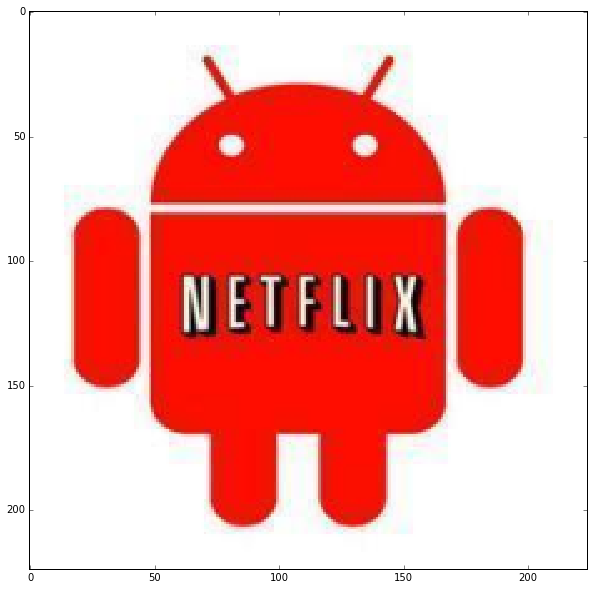

In [44]:
top_results(conflict)

Visually, this looks like an Android logo. Based on the text, one might say it is Netflix. The colors are also like that of YouTube and 3M. Not bad.

Let's take a look at the filters now. We'll also want to look at the filters, as noisy filters can be an indication that the network didn't converge, the learning rate isn't set properly, insufficient regularization, etc.

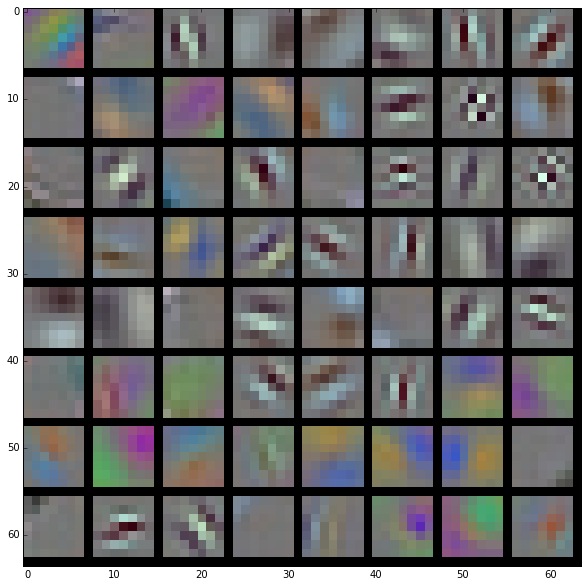

In [45]:
filters = net.params["conv1/7x7_s2"][0].data
vis_square(filters.transpose(0,2,3,1))

Not that noisy! The filters are $7 \times 7$ so they're jagged mostly because they're enlarged. We'll spare you the pain of looking at 21 other layers' filters. Let's look at the output of the first layer (first 25 only). 

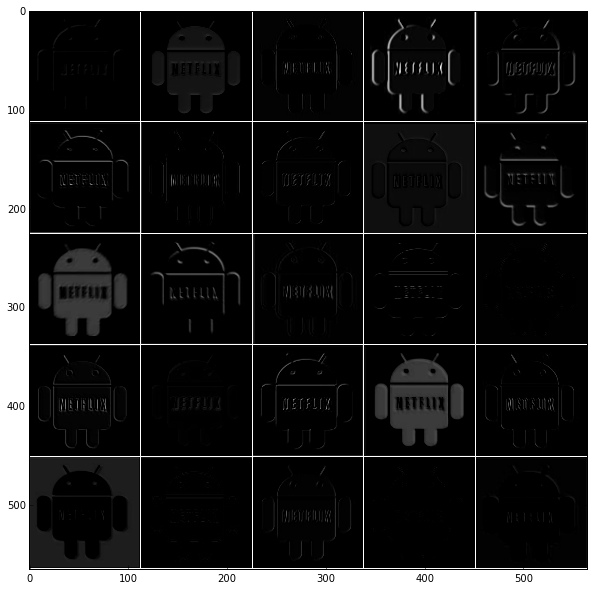

In [46]:
feat = net.blobs['conv1/7x7_s2'].data[0, :25]
vis_square(feat, padval=1)

Let's see the next layer.

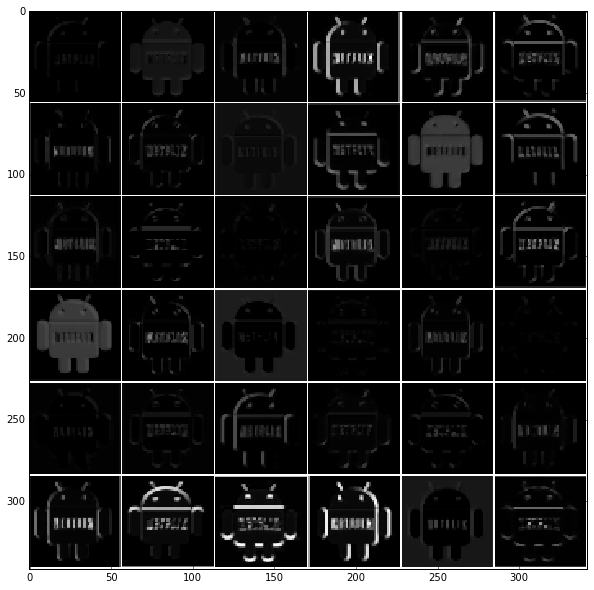

In [47]:
feat = net.blobs['pool1/3x3_s2'].data[0, :36]
vis_square(feat, padval=1)

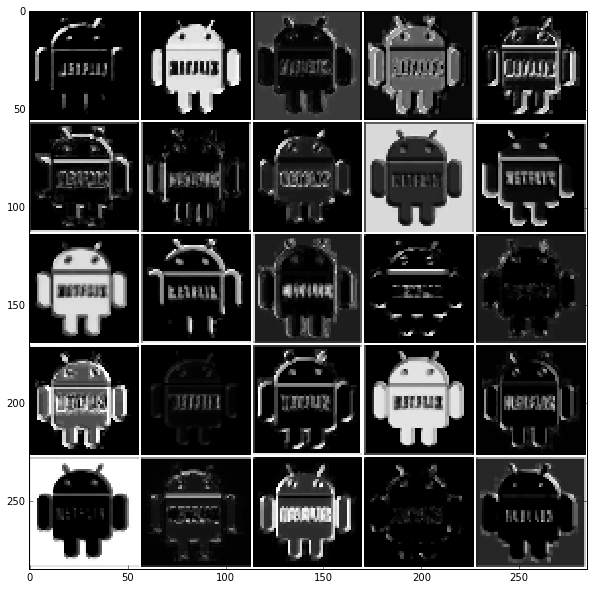

In [48]:
feat = net.blobs['pool1/norm1'].data[0, :25]
vis_square(feat, padval=1)

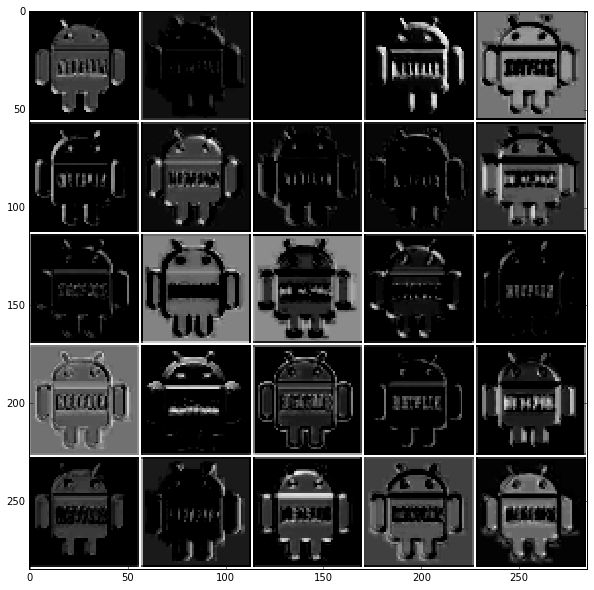

In [49]:
feat = net.blobs['conv2/3x3_reduce'].data[0, :25]
vis_square(feat, padval=1)

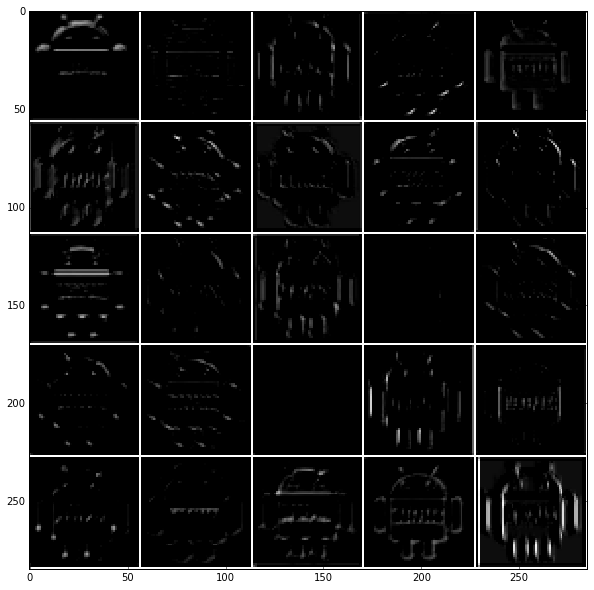

In [50]:
feat = net.blobs['conv2/3x3'].data[0, :25]
vis_square(feat, padval=1)

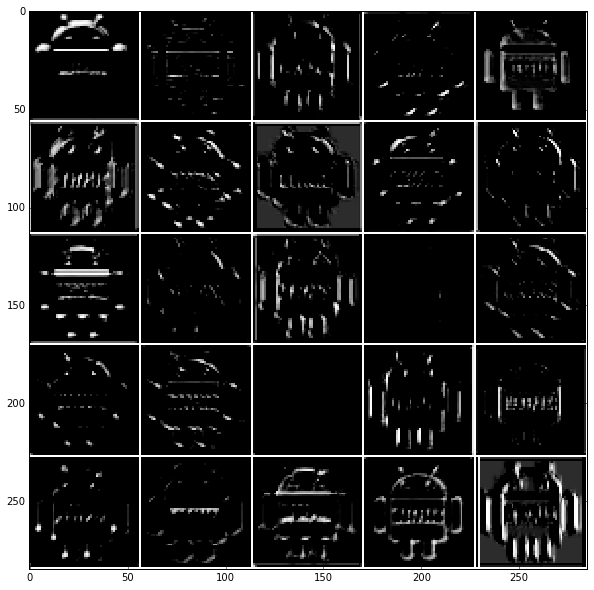

In [51]:
feat = net.blobs['conv2/norm2'].data[0, :25]
vis_square(feat, padval=1)

Okay, that's all for now. I'm not too sure how to interpret these, and we don't want to see all the layers' outputs. Here's the shape of the network.

In [52]:
[(k, v.data.shape) for k, v in net.blobs.items()]

[('data', (1, 3, 224, 224)),
 ('conv1/7x7_s2', (1, 64, 112, 112)),
 ('pool1/3x3_s2', (1, 64, 56, 56)),
 ('pool1/norm1', (1, 64, 56, 56)),
 ('conv2/3x3_reduce', (1, 64, 56, 56)),
 ('conv2/3x3', (1, 192, 56, 56)),
 ('conv2/norm2', (1, 192, 56, 56)),
 ('pool2/3x3_s2', (1, 192, 28, 28)),
 ('pool2/3x3_s2_pool2/3x3_s2_0_split_0', (1, 192, 28, 28)),
 ('pool2/3x3_s2_pool2/3x3_s2_0_split_1', (1, 192, 28, 28)),
 ('pool2/3x3_s2_pool2/3x3_s2_0_split_2', (1, 192, 28, 28)),
 ('pool2/3x3_s2_pool2/3x3_s2_0_split_3', (1, 192, 28, 28)),
 ('inception_3a/1x1', (1, 64, 28, 28)),
 ('inception_3a/3x3_reduce', (1, 96, 28, 28)),
 ('inception_3a/3x3', (1, 128, 28, 28)),
 ('inception_3a/5x5_reduce', (1, 16, 28, 28)),
 ('inception_3a/5x5', (1, 32, 28, 28)),
 ('inception_3a/pool', (1, 192, 28, 28)),
 ('inception_3a/pool_proj', (1, 32, 28, 28)),
 ('inception_3a/output', (1, 256, 28, 28)),
 ('inception_3a/output_inception_3a/output_0_split_0', (1, 256, 28, 28)),
 ('inception_3a/output_inception_3a/output_0_split_1',